In [1]:
import zfit
from zfit import z
import root_pandas
import matplotlib.pyplot as plt
import tensorflow as tf
#ZFIT_DISABLE_TF_WARNINGS=1
import numpy as np
import mplhep

/home/dinurah/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


Welcome to JupyROOT 6.24/06


In [2]:
import ROOT as r
r.gROOT.LoadMacro('/belle2work/BelleII/belle2style/Belle2Style.C') 
r.SetBelle2Style()

# Make nice looking plots
plt.rcParams.update({
          'font.size': 20,
          'figure.figsize': (12, 8),
})


Applying BELLE2 style settings...



In [3]:
# Define columns to read into memory
col = ["Lambdac_M","p_protonID_noSVD","Lambdac_cosTheta_cms","p_charge","Lambdac_p_cms","Lambdac_flightDistance"]
sigcol =["K1_kaonID_noSVD","K2_kaonID_noSVD"]
ctrcol = ["K_kaonID_noSVD"]
mccol =["Lambdac_isSignal"]
dcol = ["DST_D0_M","DST_D0_cosThetaCMS","DST_D0_pCMS","DST_D0_K_charge"]
dmccol = ["DST_isSignal"]

siginfile = '/belle2work/BelleII/Xic2Sigmahh/all_ntuples/lcp/lcp_pkk.train.root'
dinfile = '/belle2work/BelleII/Dst/Dst_mc15_1v3_MC15ri_1_merged_sWeights.root'
ctrinfile = '/belle2work/BelleII/Xic2Sigmahh/all_ntuples/lcp/lcp_pkpi.train.root'

sigdf = root_pandas.read_root(siginfile, key='lcp_pkk', columns=col+sigcol+mccol, where='Lambdac_p_cms>2.5 && p_protonID_noSVD>0.9 && Lambdac_flightDistance >0 && K1_kaonID_noSVD>0.2 &&K2_kaonID_noSVD>0.2')
ddf = root_pandas.read_root(dinfile, key='Dst', columns=dcol+dmccol)
ctrdf = root_pandas.read_root(ctrinfile, key='lcp_pkpi', columns=col+ctrcol+mccol, where='Lambdac_p_cms>2.5 && p_protonID_noSVD>0.9 && K_kaonID_noSVD>0.2 && Lambdac_flightDistance > 0')

In [4]:
# Standard plot settings
lupper = 2.34
llower = 2.23
dupper = 1.90
dlower = 1.82

In [5]:
# Standard cuts for Xi_c
lc_cut = str(llower)+' < Lambdac_M < '+str(lupper)
d_cut = str(dlower)+ ' < DST_D0_M < ' +str(dupper)

In [6]:
binedges=[-1,0,1]
bin1 = str(binedges[0])+"<=Lambdac_cosTheta_cms<"+str(binedges[1])
bin2 = str(binedges[1])+"<=Lambdac_cosTheta_cms<"+str(binedges[2])
print(bin1)
print(bin2)

-1<=Lambdac_cosTheta_cms<0
0<=Lambdac_cosTheta_cms<1


In [7]:
binedges=[-1,-0.35,0,0.35,1]
dbin1 = str(binedges[0])+"<=DST_D0_cosThetaCMS<"+str(binedges[1])
dbin2 = str(binedges[1])+"<=DST_D0_cosThetaCMS<"+str(binedges[2])
print(dbin1)
print(dbin2)

-1<=DST_D0_cosThetaCMS<-0.35
-0.35<=DST_D0_cosThetaCMS<0


In [8]:
# Simple plotting function
def plotVar(mydf, var, cuts, nbins=100, myrange=(llower,lupper), mylabel="", log=False):

    if mylabel=="":
        mylabel=var

    ax = plt.subplot()

    # define a numpy array from the given column in the dataframe
    npdata = mydf.query(cuts)[var].to_numpy()

    # create histograms
    ydata, bin_edges = np.histogram(npdata, bins=nbins, range=myrange)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(bin_centers, ydata, yerr = np.sqrt(ydata), fmt='k.', label="MC")

    #nsig = df_mc.query(lcmassrangetight+" and "+cuts+' and Lambdac_isSignal==1')[var].to_numpy().size
    #nbkg = df_mc.query(lcmassrangetight+" and "+cuts+' and not Lambdac_isSignal==1')[var].to_numpy().size
    #print(str(nsig)+" signal and "+str(nbkg)+" background -> ",nsig/(nsig+nbkg))
    
    # set plot features
    plt.ylim(0,None)
    if log==True:
        plt.ylim(0.1,None)
        plt.yscale("log")
    plt.xlim(myrange)
    plt.xlabel(mylabel)
    plt.legend(loc=0)
    plt.show()

In [9]:
# Method to overlay fitted pdfs and data sample
def plot_model(model, mydata, nevents, nbins=100, myrange=(llower,lupper), mylabel="", plot_data=True):

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4)

    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    lower, upper = mydata.data_range.limit1d

    x = tf.linspace(lower, upper, num=nbins)  # np.linspace also works
    for mod, frac in zip(model.pdfs, model.params.values()):
        y = mod.pdf(x) * nevents / nbins * mydata.data_range.area()
        y *= frac
        ax0.plot(x, y)
    data_plot = zfit.run(z.unstack_x(mydata))  # we could also use the `to_pandas` method
    y = model.pdf(x) * nevents / nbins * mydata.data_range.area()
    ax0.plot(x, y)

    counts, bin_edges = np.histogram(data_plot, bins=nbins, range=myrange)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    yerrs = counts**0.5
    ax0.errorbar(bin_centers, counts, yerr=yerrs, fmt='k.', linestyle='')
    ax0.set_xlabel(mylabel)
    ax0.set_xlim(myrange)
    ax0.set_ylim(0,None)

    X = np.ma.masked_equal(yerrs,0)
    ypull = (y-counts)/X
    ax1.errorbar(bin_centers, ypull, yerr=ypull*[0], fmt='k.', linestyle='')
    ax1.set_xlim(myrange)
    ax1.set_ylim(-5,5)

In [10]:
# D----> Kpi Simple plotting function
def DplotVar(mydf, var, cuts, nbins=100, myrange=(dlower,dupper), mylabel="", log=False):

    if mylabel=="":
        mylabel=var

    ax = plt.subplot()

    # define a numpy array from the given column in the dataframe
    npdata = mydf.query(cuts)[var].to_numpy()

    # create histograms
    ydata, bin_edges = np.histogram(npdata, bins=nbins, range=myrange)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(bin_centers, ydata, yerr = np.sqrt(ydata), fmt='k.', label="MC")

    #nsig = df_mc.query(lcmassrangetight+" and "+cuts+' and Lambdac_isSignal==1')[var].to_numpy().size
    #nbkg = df_mc.query(lcmassrangetight+" and "+cuts+' and not Lambdac_isSignal==1')[var].to_numpy().size
    #print(str(nsig)+" signal and "+str(nbkg)+" background -> ",nsig/(nsig+nbkg))
    
    # set plot features
    plt.ylim(0,None)
    if log==True:
        plt.ylim(0.1,None)
        plt.yscale("log")
    plt.xlim(myrange)
    plt.xlabel(mylabel)
    plt.legend(loc=0)
    plt.show()

In [11]:
# D -----> Kpi Method to overlay fitted pdfs and data sample
def Dplot_model(model, mydata, nevents, nbins=100, myrange=(dlower,dupper), mylabel="", plot_data=True):

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4)

    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    lower, upper = mydata.data_range.limit1d

    x = tf.linspace(lower, upper, num=nbins)  # np.linspace also works
    for mod, frac in zip(model.pdfs, model.params.values()):
        y = mod.pdf(x) * nevents / nbins * mydata.data_range.area()
        y *= frac
        ax0.plot(x, y)
    data_plot = zfit.run(z.unstack_x(mydata))  # we could also use the `to_pandas` method
    y = model.pdf(x) * nevents / nbins * mydata.data_range.area()
    ax0.plot(x, y)

    counts, bin_edges = np.histogram(data_plot, bins=nbins, range=myrange)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    yerrs = counts**0.5
    ax0.errorbar(bin_centers, counts, yerr=yerrs, fmt='k.', linestyle='')
    ax0.set_xlabel(mylabel)
    ax0.set_xlim(myrange)
    ax0.set_ylim(0,None)

    X = np.ma.masked_equal(yerrs,0)
    ypull = (y-counts)/X
    ax1.errorbar(bin_centers, ypull, yerr=ypull*[0], fmt='k.', linestyle='')
    ax1.set_xlim(myrange)
    ax1.set_ylim(-5,5)

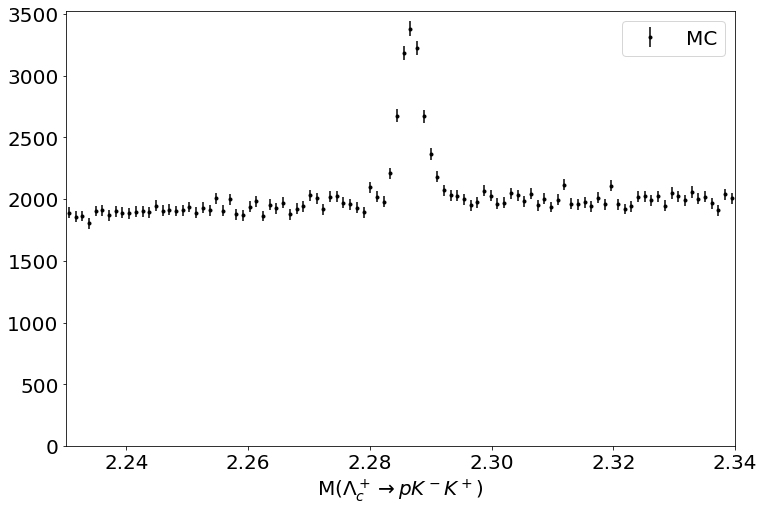

In [12]:
plotVar(sigdf,"Lambdac_M",lc_cut,mylabel=r'M($\Lambda_c^+\rightarrow p K^- K^+$)')

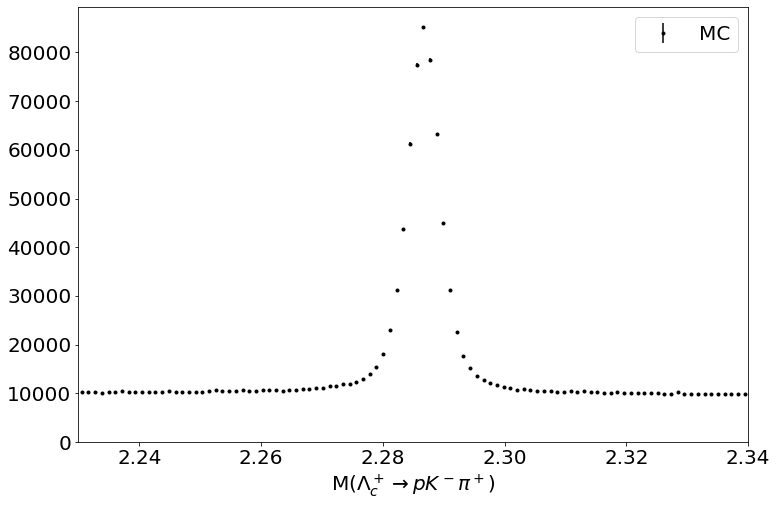

In [13]:
plotVar(ctrdf,"Lambdac_M",lc_cut,mylabel=r'M($\Lambda_c^+\rightarrow p K^- \pi^+$)')

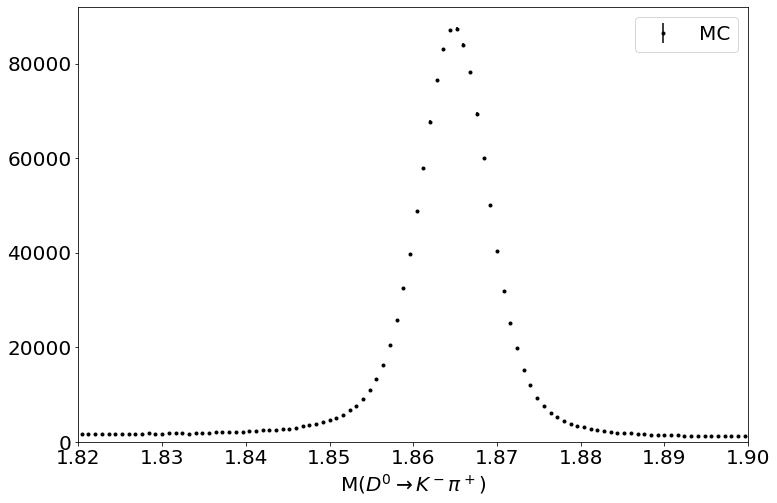

In [14]:
DplotVar(ddf,"DST_D0_M",d_cut,mylabel=r'M($D^0\rightarrow K^- \pi^+$)')

# ZFit for $\Lambda_c^+$

In [15]:
# Define default parameters for zfit
lcrange = (llower,lupper)
lcobs = zfit.Space('Lambdac_M', lcrange)
issignal = 'Lambdac_isSignal==1'

# Get the signal and background for reference
signal = sigdf.query(lc_cut + ' and Lambdac_isSignal==1').Lambdac_M.to_numpy()
bkg = sigdf.query(lc_cut + ' and Lambdac_isSignal!=1').Lambdac_M.to_numpy()
print('signal: ' + str(len(signal)))
print('bkg: ' + str(len(bkg)))

signal: 6708
bkg: 195760


In [16]:
# Signal fit parameters
mu = zfit.Parameter("mu", 2.289, 2.27, 2.3)
s1 = zfit.param.Parameter("s1", 0.020, 0.0001, 0.04)
s2 = zfit.param.Parameter("s2", 0.005, 0.0001, 0.04)
fg1 = zfit.param.Parameter("fg1", 0.20, 0., 1.)
a1 = zfit.Parameter("a1", 0.01, -1e6, 1e6)

# define PDFs
gaus1 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s1)
gaus2 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s2)
gaus = zfit.pdf.SumPDF(pdfs=[gaus1,gaus2], fracs=[fg1])

poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[a1])
sig_yield = zfit.Parameter('sig_yield', 50000, 0, 1e9, step_size=1)
bkg_yield = zfit.Parameter('bkg_yield', 500000, 0, 1e9, step_size=1)

sig_ext = gaus.create_extended(sig_yield)
bkg_ext = poly.create_extended(bkg_yield)

pdf_ext = zfit.pdf.SumPDF(pdfs=[sig_ext,bkg_ext])

# Zfit for D0

In [17]:
# D ----> Kpi Define default parameters for zfit
drange = (dlower,dupper)
dobs = zfit.Space('DST_D0_M', drange)
dissignal = 'DST_isSignal==1'

# Get the signal and background for reference
dsignal = ddf.query(d_cut + ' and DST_isSignal==1').DST_D0_M.to_numpy()
dbkg = ddf.query(d_cut + ' and DST_isSignal!=1').DST_D0_M.to_numpy()
print('signal: ' + str(len(dsignal)))
print('bkg: ' + str(len(dbkg)))

signal: 1215674
bkg: 138121


In [18]:
# D----> Kpi Signal fit parameters
dmu = zfit.Parameter("dmu", 1.864, 1.7, 2.0)
ds1 = zfit.param.Parameter("ds1", 0.020, 0.0001, 0.04)
ds2 = zfit.param.Parameter("ds2", 0.005, 0.0001, 0.04)
dfg1 = zfit.param.Parameter("dfg1", 0.20, 0., 1.)
da1 = zfit.Parameter("da1", 0.01, -1e6, 1e6)

# define PDFs
dgaus1 = zfit.pdf.Gauss(obs=dobs, mu=dmu, sigma=ds1)
dgaus2 = zfit.pdf.Gauss(obs=dobs, mu=dmu, sigma=ds2)
dgaus = zfit.pdf.SumPDF(pdfs=[dgaus1,dgaus2], fracs=[dfg1])

dpoly = zfit.pdf.Chebyshev(obs=dobs, coeffs=[da1])
dsig_yield = zfit.Parameter('dsig_yield', 50000, 0, 1e9, step_size=1)
dbkg_yield = zfit.Parameter('dbkg_yield', 500000, 0, 1e9, step_size=1)

dsig_ext = dgaus.create_extended(dsig_yield)
dbkg_ext = dpoly.create_extended(dbkg_yield)

dpdf_ext = zfit.pdf.SumPDF(pdfs=[dsig_ext,dbkg_ext])

# Signal Fit for $\Lambda_c^+\$

In [19]:
# Fill an array with the data to be fit
data_np = sigdf.query(lc_cut+' and '+issignal).Lambdac_M.to_numpy()
data = zfit.data.Data.from_numpy(obs=lcobs, array=data_np)
data.set_data_range(lcrange) 
data_size = data.n_events

In [20]:
# Fix background to zero
a1.floating = False
bkg_yield.set_value(0)
bkg_yield.floating = False

# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=pdf_ext,data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.core.data.Data object at 0x7fccad38aa30>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 6.2e-06 │ -23355.04   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
sig_yield             6708.12       False
fg1                 0.0871673       False
mu                    2.28678       False
s1                  0.0129339       False
s2                 0.00199285       False


/home/dinurah/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/dinurah/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


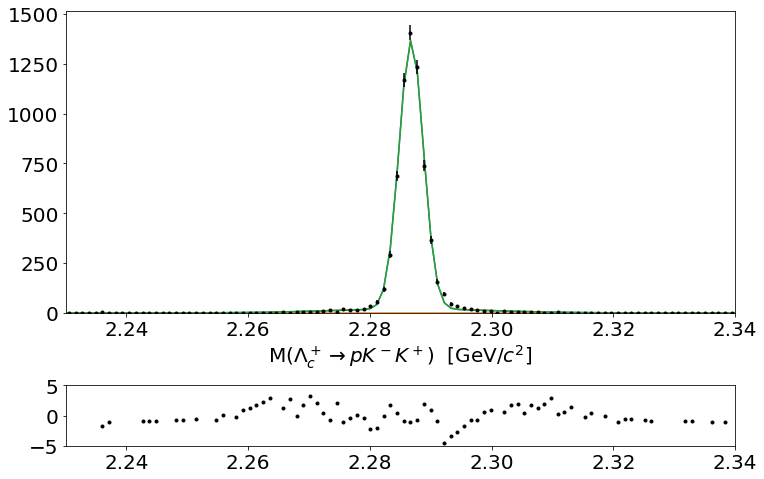

In [21]:
plot_model(model=pdf_ext, mydata=data, nevents=int(data_size), mylabel=r'M($\Lambda_c^+\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

In [22]:
# Save the signal parameters
sigmean=result.params[mu].get('value')
sigsigma1=result.params[s1].get('value')
sigsigma2=result.params[s2].get('value')
sigfg1=result.params[fg1].get('value')

# Signal Fit for D0

In [23]:
# Fill an array with the data to be fit
ddata_np = ddf.query(d_cut+' and '+dissignal).DST_D0_M.to_numpy()
ddata = zfit.data.Data.from_numpy(obs=dobs, array=ddata_np)
ddata.set_data_range(drange) 
ddata_size = ddata.n_events

In [24]:
# Fix background to zero
da1.floating = False
dbkg_yield.set_value(0)
dbkg_yield.floating = False

# Define loss function
dnll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=dpdf_ext,data=ddata)
dminimizer = zfit.minimize.Minuit()
dresult = dminimizer.minimize(dnll_simultaneous)  
print(dresult)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_12, Composed_autoparam_13]] data=[<zfit.core.data.Data object at 0x7fccad40a370>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.2e-05 │ -2744963    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
dsig_yield         1.21567e+06       False
dfg1                   0.13262       False
dmu                    1.86471       False
ds1                  0.0171882       False
ds2                 0.00435039       False


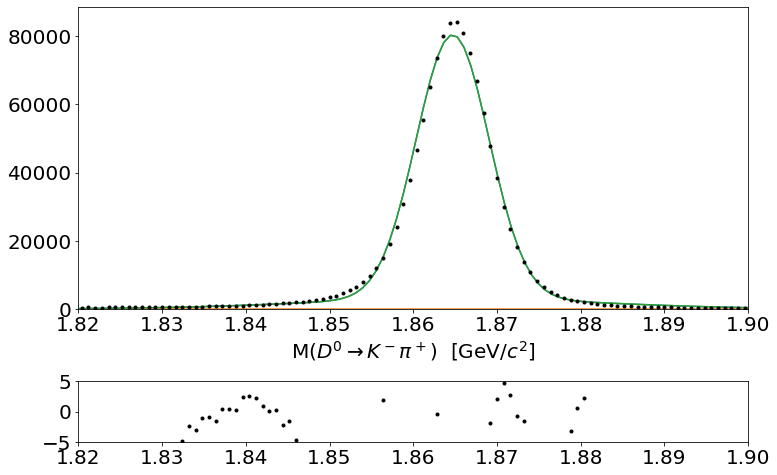

In [25]:
Dplot_model(model=dpdf_ext, mydata=ddata, nevents=int(ddata_size), mylabel=r'M($D^0\rightarrow K^- \pi^+$)  [GeV/$c^{2}$]')

In [26]:
# Save the signal parameters
dsigmean=dresult.params[dmu].get('value')
dsigsigma1=dresult.params[ds1].get('value')
dsigsigma2=dresult.params[ds2].get('value')
dsigfg1=dresult.params[dfg1].get('value')

## $D^0 \rightarrow K^-\pi^+\$ Integrated fit

In [27]:
# Fill an array with the data to be fit
ddata_np_integ = ddf.query(d_cut).DST_D0_M.to_numpy()
ddata_integ = zfit.data.Data.from_numpy(obs=dobs, array=ddata_np_integ)
ddata_integ.set_data_range(drange) 
ddata_size_integ = ddata_integ.n_events

In [28]:
# Float background
da1.floating = True
dbkg_yield.set_value(10000)
dbkg_yield.floating = True

# Fix signal shape
ds1.floating = False
ds1.set_value(dsigsigma1)
ds2.floating = False
ds2.set_value(dsigsigma2)
dfg1.floating = False
dfg1.set_value(dsigfg1)

# Define loss function
dnll_simultaneous_integ = zfit.loss.ExtendedUnbinnedNLL(model=dpdf_ext,data=ddata_integ)
dminimizer = zfit.minimize.Minuit()
dresult_integ = dminimizer.minimize(dnll_simultaneous_integ)  
print(dresult_integ)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_12, Composed_autoparam_13]] data=[<zfit.core.data.Data object at 0x7fcc80671d30>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 3.7e-06 │ -26735.6    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
dsig_yield         1.25201e+06       False
dbkg_yield              101785       False
dmu                    1.86476       False
da1                  -0.505189       False


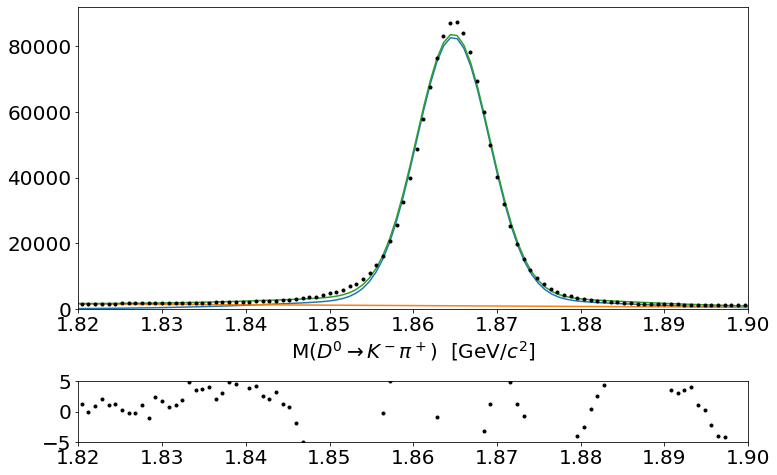

In [29]:
Dplot_model(model=dpdf_ext, mydata=ddata_integ, nevents=int(ddata_size_integ), mylabel=r'M($D^0\rightarrow K^- \pi^+$)  [GeV/$c^{2}$]')

## $\Lambda_c^+\rightarrow p K^- K^+\$ Integrated fit

In [30]:
# Fill an array with the data to be fit
data_np = sigdf.query(lc_cut).Lambdac_M.to_numpy()
data = zfit.data.Data.from_numpy(obs=lcobs, array=data_np)
data.set_data_range(lcrange) 
data_size = data.n_events

In [31]:
# Float background
a1.floating = True
bkg_yield.set_value(10000)
bkg_yield.floating = True

# Fix signal shape
s1.floating = False
s1.set_value(sigsigma1)
s2.floating = False
s2.set_value(sigsigma2)
fg1.floating = False
fg1.set_value(sigfg1)

# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=pdf_ext,data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.core.data.Data object at 0x7fcc8074e460>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 9.2e-05 │ -358168.7   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
sig_yield              6924.9       False
bkg_yield              195543       False
mu                    2.28674       False
a1                  0.0336717       False


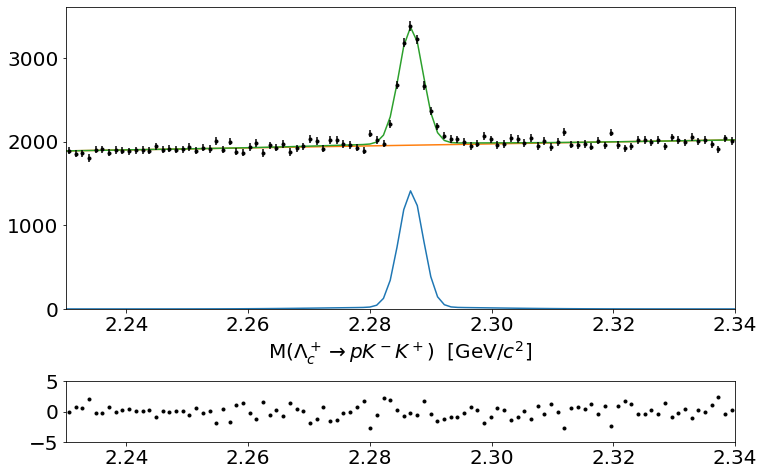

In [32]:
plot_model(model=pdf_ext, mydata=data, nevents=int(data_size), mylabel=r'M($\Lambda_c^+\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

## $\Lambda_c^+ \rightarrow pK^-\pi^+$ Integrated fit

In [33]:
# Fill an array with the data to be fit
data_np = ctrdf.query(lc_cut).Lambdac_M.to_numpy()
data = zfit.data.Data.from_numpy(obs=lcobs, array=data_np)
data.set_data_range(lcrange) 
data_size = data.n_events

In [34]:
# Fix signal shape
s1.floating = True
s1.set_value(sigsigma1)
s2.floating = True
s2.set_value(sigsigma2)
fg1.floating = True
fg1.set_value(sigfg1)


# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=pdf_ext,data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.core.data.Data object at 0x7fcc80153d30>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00012 │ -2034013    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
sig_yield              504034       False
bkg_yield         1.02626e+06       False
fg1                  0.750517       False
mu                    2.28667       False
s1                 0.00250386       False
s2                 0.00702096       False
a1                 -0.0257797       False


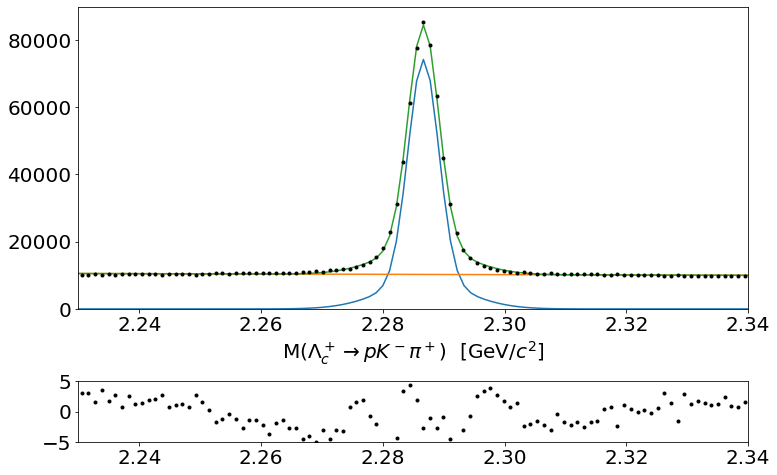

In [35]:
plot_model(model=pdf_ext, mydata=data, myrange=lcrange, nevents=int(data_size), mylabel=r'M($\Lambda_c^+\rightarrow p K^- \pi^+$)  [GeV/$c^{2}$]')

# Fits in cos($\theta$) bins for $\Lambda_c^+\rightarrow p \pi^- \pi^+$ & $\Lambda_c^+\rightarrow p K^- \pi^+$

In [36]:
nsigtrue=[]
nasigtrue=[]
nsig=[]
nasig=[]

nsigtruee=[]
nasigtruee=[]
nsige=[]
nasige=[]

In [37]:
nctrtrue=[]
nactrtrue=[]
nctr=[]
nactr=[]

nctrtruee=[]
nactrtruee=[]
nctre=[]
nactre=[]

In [38]:
# signal fit parameters
sig_s1 = zfit.Parameter("sig_s1", sigsigma1)
sig_s1.floating = False
sig_s2 = zfit.Parameter("sig_s2", sigsigma2)
sig_s2.floating = False
sig_fg1 = zfit.Parameter("sig_fg1", sigfg1)
sig_fg1.floating = False

sig_a1 = zfit.Parameter("sig_a1", 0.01, -1e6, 1e6)
asig_a1 = zfit.Parameter("asig_a1", 0.01, -1e6, 1e6)

# define PDFs
sig_gaus1 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=sig_s1)
sig_gaus2 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=sig_s2)
sig_gaus = zfit.pdf.SumPDF(pdfs=[sig_gaus1,sig_gaus2], fracs=[sig_fg1])

sig_poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[sig_a1])

sig_sig_yield = zfit.Parameter('sig_sig_yield', 5000, 0, 1e8, step_size=1)
sig_bkg_yield = zfit.Parameter('sig_bkg_yield', 50000, 0, 1e9, step_size=1)

sig_sig_ext = sig_gaus.create_extended(sig_sig_yield)
sig_bkg_ext = sig_poly.create_extended(sig_bkg_yield)

sig_pdf_ext = zfit.pdf.SumPDF(pdfs=[sig_sig_ext,sig_bkg_ext])

asig_gaus1 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=sig_s1)
asig_gaus2 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=sig_s2)
asig_gaus = zfit.pdf.SumPDF(pdfs=[asig_gaus1,asig_gaus2], fracs=[sig_fg1])

asig_poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[asig_a1])

asig_sig_yield = zfit.Parameter('asig_sig_yield', 5000, 0, 1e8, step_size=1)
asig_bkg_yield = zfit.Parameter('asig_bkg_yield', 50000, 0, 1e9, step_size=1)

asig_sig_ext = asig_gaus.create_extended(asig_sig_yield)
asig_bkg_ext = asig_poly.create_extended(asig_bkg_yield)

asig_pdf_ext = zfit.pdf.SumPDF(pdfs=[asig_sig_ext,asig_bkg_ext])

In [39]:
# Fit parameters
ctr_fg1 = zfit.Parameter("ctr_fg1", 0.20, 0., 1.)
ctr_a1 = zfit.Parameter("ctr_a1", 0.01, -1e6, 1e6)

actr_fg1 = zfit.Parameter("actr_fg1", 0.20, 0., 1.)
actr_a1 = zfit.Parameter("actr_a1", 0.01, -1e6, 1e6)

# define PDFs
ctr_gaus1 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s1)
ctr_gaus2 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s2)
ctr_gaus = zfit.pdf.SumPDF(pdfs=[ctr_gaus1,ctr_gaus2], fracs=[ctr_fg1])

ctr_poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[ctr_a1])

ctr_sig_yield = zfit.Parameter('ctr_sig_yield', 5000, 0, 1e8, step_size=1)
ctr_bkg_yield = zfit.Parameter('ctr_bkg_yield', 50000, 0, 1e9, step_size=1)

ctr_sig_ext = ctr_gaus.create_extended(ctr_sig_yield)
ctr_bkg_ext = ctr_poly.create_extended(ctr_bkg_yield)

ctr_pdf_ext = zfit.pdf.SumPDF(pdfs=[ctr_sig_ext,ctr_bkg_ext])

actr_gaus1 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s1)
actr_gaus2 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s2)
actr_gaus = zfit.pdf.SumPDF(pdfs=[actr_gaus1,actr_gaus2], fracs=[actr_fg1])

actr_poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[actr_a1])

actr_sig_yield = zfit.Parameter('actr_sig_yield', 5000, 0, 1e8, step_size=1)
actr_bkg_yield = zfit.Parameter('actr_bkg_yield', 50000, 0, 1e9, step_size=1)

actr_sig_ext = actr_gaus.create_extended(actr_sig_yield)
actr_bkg_ext = actr_poly.create_extended(actr_bkg_yield)

actr_pdf_ext = zfit.pdf.SumPDF(pdfs=[actr_sig_ext,actr_bkg_ext])

## bin 1

In [40]:
print(bin1)

-1<=Lambdac_cosTheta_cms<0


In [41]:
# Get the signal and background for reference
sig_signal = sigdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==1').Lambdac_M.to_numpy()
sig_bkg = sigdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal!=1 and p_charge==1').Lambdac_M.to_numpy()
print('sig signal: ' + str(len(sig_signal)))
print('sig bkg: ' + str(len(sig_bkg)))
nsigtrue.append(len(sig_signal))

asig_signal = sigdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==-1').Lambdac_M.to_numpy()
asig_bkg = sigdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal!=1 and p_charge==-1').Lambdac_M.to_numpy()
print('asig signal: ' + str(len(asig_signal)))
print('asig bkg: ' + str(len(asig_bkg)))
nasigtrue.append(len(asig_signal))

# Get the signal and background for reference
ctr_signal = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==1').Lambdac_M.to_numpy()
ctr_bkg = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal!=1 and p_charge==1').Lambdac_M.to_numpy()
print('ctr signal: ' + str(len(ctr_signal)))
print('ctr bkg: ' + str(len(ctr_bkg)))
nctrtrue.append(len(ctr_signal))

actr_signal = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==-1').Lambdac_M.to_numpy()
actr_bkg = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal!=1 and p_charge==-1').Lambdac_M.to_numpy()
print('actr signal: ' + str(len(actr_signal)))
print('actr bkg: ' + str(len(actr_bkg)))
nactrtrue.append(len(actr_signal))

sig signal: 1869
sig bkg: 49600
asig signal: 1661
asig bkg: 44156
ctr signal: 139672
ctr bkg: 259650
actr signal: 123560
actr bkg: 225421


In [42]:
# Fill an array with the data to be fit
sig_data_np = sigdf.query(lc_cut+" and "+bin1+' and p_charge==1').Lambdac_M.to_numpy()
sig_data = zfit.data.Data.from_numpy(obs=lcobs, array=sig_data_np)
sig_data.set_data_range(lcrange)
sig_data_size = sig_data.n_events

asig_data_np = sigdf.query(lc_cut+" and "+bin1+' and p_charge==-1').Lambdac_M.to_numpy()
asig_data = zfit.data.Data.from_numpy(obs=lcobs, array=asig_data_np)
asig_data.set_data_range(lcrange)
asig_data_size = asig_data.n_events

ctr_data_np = ctrdf.query(lc_cut+" and "+bin1+' and p_charge==1').Lambdac_M.to_numpy()
ctr_data = zfit.data.Data.from_numpy(obs=lcobs, array=ctr_data_np)
ctr_data.set_data_range(lcrange)
ctr_data_size = ctr_data.n_events

actr_data_np = ctrdf.query(lc_cut+" and "+bin1+' and p_charge==-1').Lambdac_M.to_numpy()
actr_data = zfit.data.Data.from_numpy(obs=lcobs, array=actr_data_np)
actr_data.set_data_range(lcrange)
actr_data_size = actr_data.n_events

print(int(sig_data_size))
print(int(asig_data_size))
print(int(ctr_data_size))
print(int(actr_data_size))

51469
45817
399322
348981


In [43]:
# Simultaenous loss
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=[sig_pdf_ext,asig_pdf_ext,ctr_pdf_ext,actr_pdf_ext], data=[sig_data,asig_data,ctr_data,actr_data])
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)

In [44]:
result.hesse()
errors, new_result = result.errors()
print(result)

/home/dinurah/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1180: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")
/home/dinurah/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1316: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(meth

FitResult of
<ExtendedUnbinnedNLL model=multiple data=multiple constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm    │ min value   │
╞═════════╪═════════════╪══════════════════╪════════╪═════════════╡
│ True    │ True        │ False            │ 0.0026 │ -908998.5   │
╘═════════╧═════════════╧══════════════════╧════════╧═════════════╛

Parameters
name              value  (rounded)        hesse               errors         minuit_minos    at limit
--------------  ------------------  -----------  -------------------  -------------------  ----------
sig_sig_yield              1930.04  +/-      79  -     79   +     80  -     79   +     80       False
sig_bkg_yield              49538.5  +/- 2.3e+02  -2.3e+02   +2.3e+02  -2.3e+02   +2.3e+02       False
mu                         2.28663  +/- 7.5e-06  -7.5e-06   +7.5e-06  -7.5e-06   +7.5e-06       False
sig_a1                   0

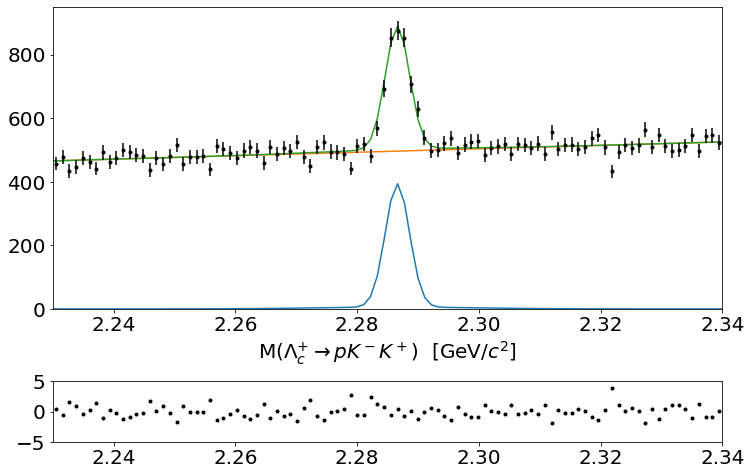

In [45]:
plot_model(model=sig_pdf_ext, mydata=sig_data, nevents=int(sig_data_size), mylabel=r'M($\Lambda_{c}^{+}\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

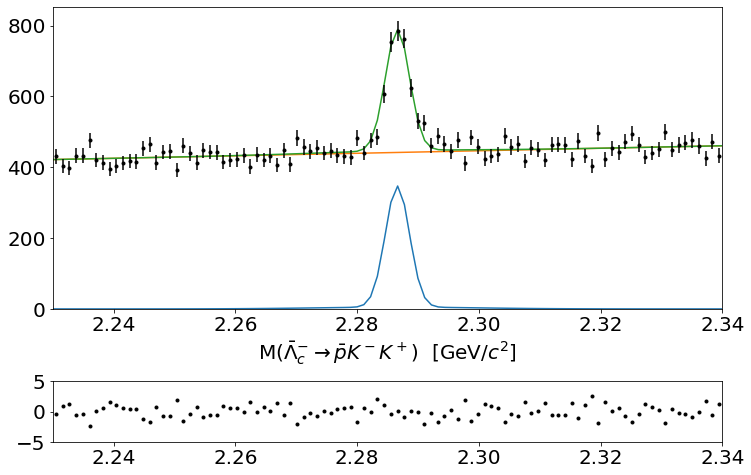

In [46]:
plot_model(model=asig_pdf_ext, mydata=asig_data, nevents=int(asig_data_size), mylabel=r'M($\bar{\Lambda}_{c}^{-}\rightarrow \barp K^- K^+$)  [GeV/$c^{2}$]')

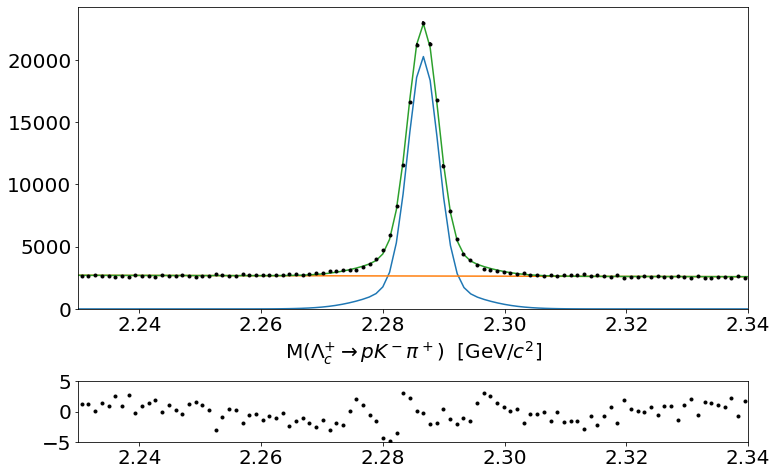

In [47]:
plot_model(model=ctr_pdf_ext, mydata=ctr_data, nevents=int(ctr_data_size), mylabel=r'M($\Lambda_{c}^{+}\rightarrow p K^- \pi^+$)  [GeV/$c^{2}$]')

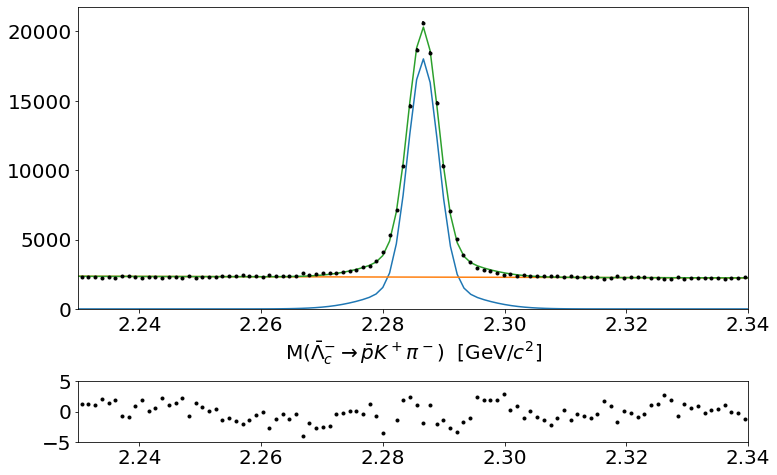

In [48]:
plot_model(model=actr_pdf_ext, mydata=actr_data, nevents=int(actr_data_size), mylabel=r'M($\bar{\Lambda}_{c}^{-}\rightarrow \barp K^+ \pi^-$)  [GeV/$c^{2}$]')

In [49]:
nsig.append(result.params[sig_sig_yield].get('value'))
nsige.append(result.params[sig_sig_yield].get('hesse').get('error'))
nasig.append(result.params[asig_sig_yield].get('value'))
nasige.append(result.params[asig_sig_yield].get('hesse').get('error'))

nctr.append(result.params[ctr_sig_yield].get('value'))
nctre.append(result.params[ctr_sig_yield].get('hesse').get('error'))
nactr.append(result.params[actr_sig_yield].get('value'))
nactre.append(result.params[actr_sig_yield].get('hesse').get('error'))

## bin 2

In [50]:
print(bin2)

0<=Lambdac_cosTheta_cms<1


In [51]:
# Get the signal and background for reference
sig_signal = sigdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==1').Lambdac_M.to_numpy()
sig_bkg = sigdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal!=1 and p_charge==1').Lambdac_M.to_numpy()
print('sig signal: ' + str(len(sig_signal)))
print('sig bkg: ' + str(len(sig_bkg)))
nsigtrue.append(len(sig_signal))

asig_signal = sigdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==-1').Lambdac_M.to_numpy()
asig_bkg = sigdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal!=1 and p_charge==-1').Lambdac_M.to_numpy()
print('asig signal: ' + str(len(asig_signal)))
print('asig bkg: ' + str(len(asig_bkg)))
nasigtrue.append(len(asig_signal))

# Get the signal and background for reference
ctr_signal = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==1').Lambdac_M.to_numpy()
ctr_bkg = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal!=1 and p_charge==1').Lambdac_M.to_numpy()
print('ctr signal: ' + str(len(ctr_signal)))
print('ctr bkg: ' + str(len(ctr_bkg)))
nctrtrue.append(len(ctr_signal))

actr_signal = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==-1').Lambdac_M.to_numpy()
actr_bkg = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal!=1 and p_charge==-1').Lambdac_M.to_numpy()
print('actr signal: ' + str(len(actr_signal)))
print('actr bkg: ' + str(len(actr_bkg)))
nactrtrue.append(len(actr_signal))

sig signal: 1636
sig bkg: 52499
asig signal: 1542
asig bkg: 49505
ctr signal: 132158
ctr bkg: 273599
actr signal: 125099
actr bkg: 251121


In [52]:
# Fill an array with the data to be fit
sig_data_np = sigdf.query(lc_cut+" and "+bin2+' and p_charge==1').Lambdac_M.to_numpy()
sig_data = zfit.data.Data.from_numpy(obs=lcobs, array=sig_data_np)
sig_data.set_data_range(lcrange)
sig_data_size = sig_data.n_events

asig_data_np = sigdf.query(lc_cut+" and "+bin2+' and p_charge==-1').Lambdac_M.to_numpy()
asig_data = zfit.data.Data.from_numpy(obs=lcobs, array=asig_data_np)
asig_data.set_data_range(lcrange)
asig_data_size = asig_data.n_events

ctr_data_np = ctrdf.query(lc_cut+" and "+bin2+' and p_charge==1').Lambdac_M.to_numpy()
ctr_data = zfit.data.Data.from_numpy(obs=lcobs, array=ctr_data_np)
ctr_data.set_data_range(lcrange)
ctr_data_size = ctr_data.n_events

actr_data_np = ctrdf.query(lc_cut+" and "+bin2+' and p_charge==-1').Lambdac_M.to_numpy()
actr_data = zfit.data.Data.from_numpy(obs=lcobs, array=actr_data_np)
actr_data.set_data_range(lcrange)
actr_data_size = actr_data.n_events

print(int(sig_data_size))
print(int(asig_data_size))
print(int(ctr_data_size))
print(int(actr_data_size))

54135
51047
405757
376220


In [53]:
# Simultaenous loss
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=[sig_pdf_ext,asig_pdf_ext,ctr_pdf_ext,actr_pdf_ext], data=[sig_data,asig_data,ctr_data,actr_data])
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)

In [54]:
result.hesse()
errors, new_result = result.errors()
print(result)

/home/dinurah/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1316: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


FitResult of
<ExtendedUnbinnedNLL model=multiple data=multiple constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 8.2e-05 │ 7628.271    │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name              value  (rounded)        hesse               errors         minuit_minos    at limit
--------------  ------------------  -----------  -------------------  -------------------  ----------
sig_sig_yield              1751.15  +/-      79  -     79   +     80  -     79   +     80       False
sig_bkg_yield              52384.5  +/- 2.4e+02  -2.4e+02   +2.4e+02  -2.4e+02   +2.4e+02       False
mu                         2.28672  +/- 8.1e-06  -8.1e-06   +8.1e-06  -8.1e-06   +8.1e-06       False
sig_a1               

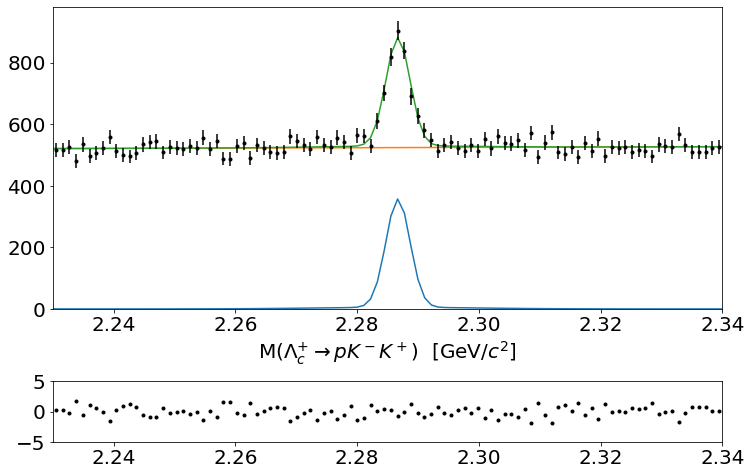

In [55]:
plot_model(model=sig_pdf_ext, mydata=sig_data, nevents=int(sig_data_size), mylabel=r'M($\Lambda_{c}^{+}\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

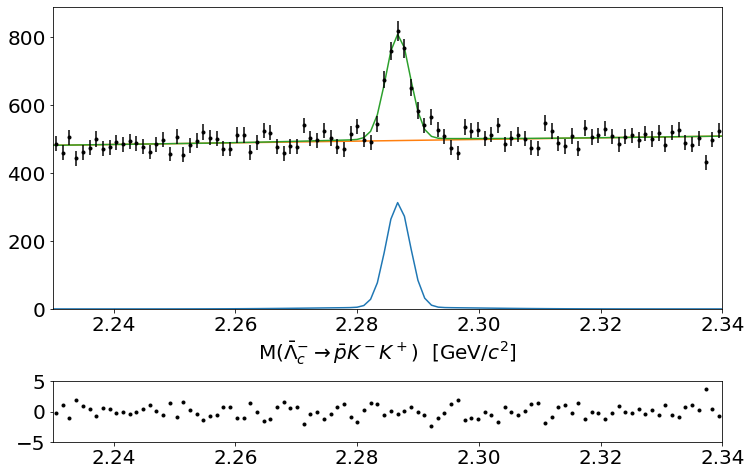

In [56]:
plot_model(model=asig_pdf_ext, mydata=asig_data, nevents=int(asig_data_size), mylabel=r'M($\bar\Lambda_{c}^{-}\rightarrow \barp K^- K^+$)  [GeV/$c^{2}$]')

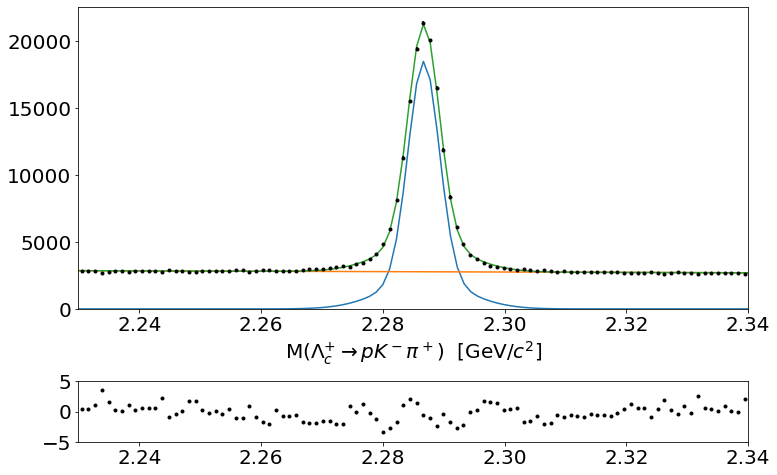

In [57]:
plot_model(model=ctr_pdf_ext, mydata=ctr_data, nevents=int(ctr_data_size), mylabel=r'M($\Lambda_{c}^{+}\rightarrow p K^- \pi^+$)  [GeV/$c^{2}$]')

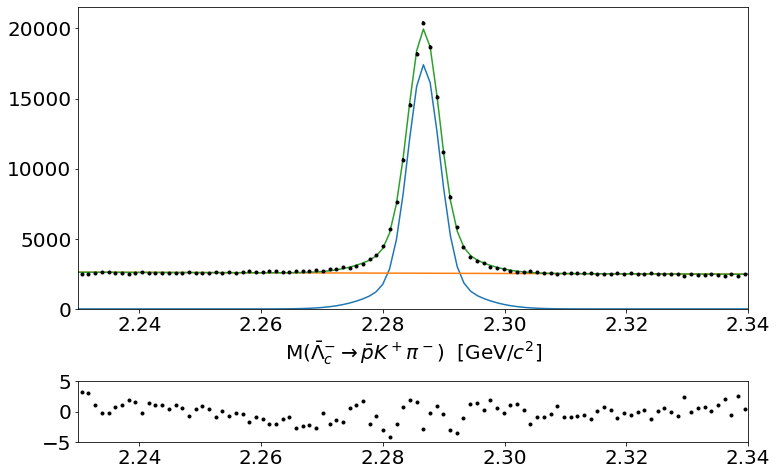

In [58]:
plot_model(model=actr_pdf_ext, mydata=actr_data, nevents=int(actr_data_size), mylabel=r'M($\bar\Lambda_{c}^{-}\rightarrow \barp K^+ \pi^-$)  [GeV/$c^{2}$]')

In [59]:
nsig.append(result.params[sig_sig_yield].get('value'))
nsige.append(result.params[sig_sig_yield].get('hesse').get('error'))
nasig.append(result.params[asig_sig_yield].get('value'))
nasige.append(result.params[asig_sig_yield].get('hesse').get('error'))

nctr.append(result.params[ctr_sig_yield].get('value'))
nctre.append(result.params[ctr_sig_yield].get('hesse').get('error'))
nactr.append(result.params[actr_sig_yield].get('value'))
nactre.append(result.params[actr_sig_yield].get('hesse').get('error'))

In [60]:
print(nsigtrue)
print(nsig)
print(nasigtrue)
print(nasig)

[1869, 1636]
[1930.0367539865304, 1751.151524148373]
[1661, 1542]
[1701.3777897885966, 1534.7400707717416]


In [61]:
import uncertainties as un
from uncertainties import unumpy

In [62]:
sigar = unumpy.uarray(nsig,nsige)
asigar = unumpy.uarray(nasig,nasige)
ctrar = unumpy.uarray(nctr,nctre)
actrar = unumpy.uarray(nactr,nactre)

In [63]:
nsigtruee = np.sqrt(nsigtrue)
nasigtruee = np.sqrt(nasigtrue)
nctrtruee = np.sqrt(nctrtrue)
nactrtruee = np.sqrt(nactrtrue)

In [64]:
trsigar = unumpy.uarray(nsigtrue,nsigtruee)
trasigar = unumpy.uarray(nasigtrue,nasigtruee)
trctrar = unumpy.uarray(nctrtrue,nctrtruee)
tractrar = unumpy.uarray(nactrtrue,nactrtruee)

# Fits in cos($\theta$) bins for \$D^0$

In [65]:
ndtrue=[]
nadtrue=[]
nd=[]
nad=[]

ndtruee=[]
nadtruee=[]
nde=[]
nade=[]

In [66]:
# signal fit parameters
d_s1 = zfit.Parameter("d_s1", dsigsigma1)
d_s1.floating = False
d_s2 = zfit.Parameter("d_s2", dsigsigma2)
d_s2.floating = False
d_fg1 = zfit.Parameter("d_fg1", dsigfg1)
d_fg1.floating = False

d_a1 = zfit.Parameter("d_a1", 0.01, -1e6, 1e6)
ad_a1 = zfit.Parameter("ad_a1", 0.01, -1e6, 1e6)

# define PDFs
d_gaus1 = zfit.pdf.Gauss(obs=dobs, mu=dmu, sigma=d_s1)
d_gaus2 = zfit.pdf.Gauss(obs=dobs, mu=dmu, sigma=d_s2)
d_gaus = zfit.pdf.SumPDF(pdfs=[d_gaus1,d_gaus2], fracs=[d_fg1])

d_poly = zfit.pdf.Chebyshev(obs=dobs, coeffs=[d_a1])

d_sig_yield = zfit.Parameter('d_sig_yield', 5000, 0, 1e8, step_size=1)
d_bkg_yield = zfit.Parameter('d_bkg_yield', 50000, 0, 1e9, step_size=1)

d_sig_ext = d_gaus.create_extended(d_sig_yield)
d_bkg_ext = d_poly.create_extended(d_bkg_yield)

d_pdf_ext = zfit.pdf.SumPDF(pdfs=[d_sig_ext,d_bkg_ext])

ad_gaus1 = zfit.pdf.Gauss(obs=dobs, mu=dmu, sigma=d_s1)
ad_gaus2 = zfit.pdf.Gauss(obs=dobs, mu=dmu, sigma=d_s2)
ad_gaus = zfit.pdf.SumPDF(pdfs=[ad_gaus1,ad_gaus2], fracs=[d_fg1])

ad_poly = zfit.pdf.Chebyshev(obs=dobs, coeffs=[ad_a1])

ad_sig_yield = zfit.Parameter('ad_sig_yield', 5000, 0, 1e8, step_size=1)
ad_bkg_yield = zfit.Parameter('ad_bkg_yield', 50000, 0, 1e9, step_size=1)

ad_sig_ext = ad_gaus.create_extended(ad_sig_yield)
ad_bkg_ext = ad_poly.create_extended(ad_bkg_yield)

ad_pdf_ext = zfit.pdf.SumPDF(pdfs=[ad_sig_ext,ad_bkg_ext])

## bin 1 for \$D^0$

In [67]:
print(dbin1)

-1<=DST_D0_cosThetaCMS<-0.35


In [68]:
# Get the signal and background for reference
d_signal = ddf.query(d_cut+" and "+dbin1+' and DST_isSignal==1 and DST_D0_K_charge==-1').DST_D0_M.to_numpy()
d_bkg = ddf.query(d_cut+" and "+dbin1+' and DST_isSignal==1 and DST_D0_K_charge==-1').DST_D0_M.to_numpy()
print('d signal: ' + str(len(d_signal)))
print('d bkg: ' + str(len(d_bkg)))
ndtrue.append(len(d_signal))

ad_signal = ddf.query(d_cut+" and "+dbin1+' and DST_isSignal==1 and DST_D0_K_charge==1').DST_D0_M.to_numpy()
ad_bkg = ddf.query(d_cut+" and "+dbin1+' and DST_isSignal==1 and DST_D0_K_charge==1').DST_D0_M.to_numpy()
print('ad signal: ' + str(len(ad_signal)))
print('ad bkg: ' + str(len(ad_bkg)))
nadtrue.append(len(ad_signal))

d signal: 177161
d bkg: 177161
ad signal: 170063
ad bkg: 170063


In [69]:
# Fill an array with the data to be fit
d_data_np = ddf.query(d_cut+" and "+dbin1+' and DST_D0_K_charge==-1').DST_D0_M.to_numpy()
d_data = zfit.data.Data.from_numpy(obs=dobs, array=d_data_np)
d_data.set_data_range(drange)
d_data_size = d_data.n_events

ad_data_np = ddf.query(d_cut+" and "+dbin1+' and DST_D0_K_charge==1').DST_D0_M.to_numpy()
ad_data = zfit.data.Data.from_numpy(obs=dobs, array=ad_data_np)
ad_data.set_data_range(drange)
ad_data_size = ad_data.n_events

print(int(d_data_size))
print(int(ad_data_size))

199848
192090


In [70]:
# Simultaenous loss
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=[d_pdf_ext,ad_pdf_ext], data=[d_data,ad_data])
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)

In [71]:
result.hesse()
errors, new_result = result.errors()
print(result)

/home/dinurah/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1316: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_47, Composed_autoparam_48], <zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_54, Composed_autoparam_55]] data=[<zfit.core.data.Data object at 0x7fcc40c8afd0>, <zfit.core.data.Data object at 0x7fcc40db8910>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.5e-06 │ -472533.4   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name            value  (rounded)        hesse               errors         minuit_minos    at limit
------------  ------------------  -----------  -------------------  -------------------  ----------
d_sig_yield               179527  +/- 4.6e+02  -4.6e+

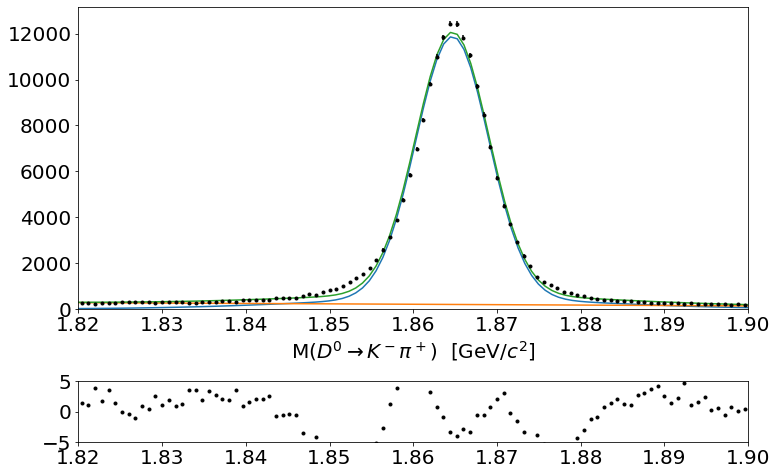

In [72]:
Dplot_model(model=d_pdf_ext, mydata=d_data, nevents=int(d_data_size), mylabel=r'M($D^0\rightarrow K^- \pi^+$)  [GeV/$c^{2}$]')

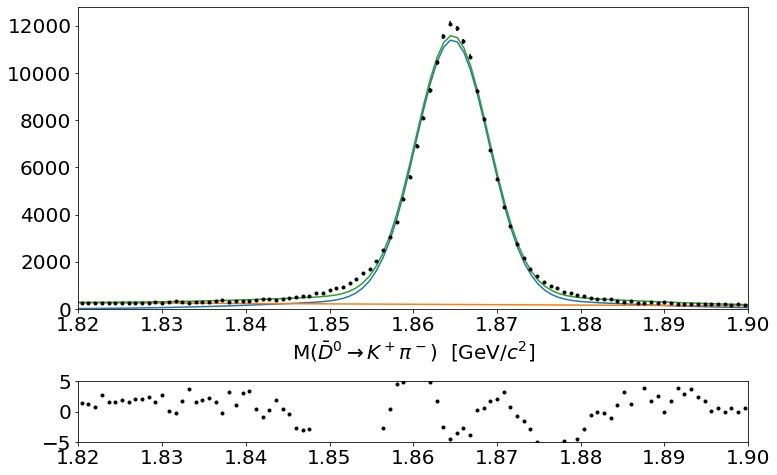

In [73]:
Dplot_model(model=ad_pdf_ext, mydata=ad_data, nevents=int(ad_data_size), mylabel=r'M($\barD^0\rightarrow K^+ \pi^-$)  [GeV/$c^{2}$]')

In [74]:
nd.append(result.params[d_sig_yield].get('value'))
nde.append(result.params[d_sig_yield].get('hesse').get('error'))
nad.append(result.params[ad_sig_yield].get('value'))
nade.append(result.params[ad_sig_yield].get('hesse').get('error'))

## bin 2 for \$D^0$

In [75]:
print(dbin2)

-0.35<=DST_D0_cosThetaCMS<0


In [76]:
# Get the signal and background for reference
d_signal = ddf.query(d_cut+" and "+dbin2+' and DST_isSignal==1 and DST_D0_K_charge==-1').DST_D0_M.to_numpy()
d_bkg = ddf.query(d_cut+" and "+dbin2+' and DST_isSignal==1 and DST_D0_K_charge==-1').DST_D0_M.to_numpy()
print('d signal: ' + str(len(d_signal)))
print('d bkg: ' + str(len(d_bkg)))
ndtrue.append(len(d_signal))

ad_signal = ddf.query(d_cut+" and "+dbin2+' and DST_isSignal==1 and DST_D0_K_charge==1').DST_D0_M.to_numpy()
ad_bkg = ddf.query(d_cut+" and "+dbin2+' and DST_isSignal==1 and DST_D0_K_charge==1').DST_D0_M.to_numpy()
print('ad signal: ' + str(len(ad_signal)))
print('ad bkg: ' + str(len(ad_bkg)))
nadtrue.append(len(ad_signal))

d signal: 112508
d bkg: 112508
ad signal: 104907
ad bkg: 104907


In [77]:
# Fill an array with the data to be fit
d_data_np = ddf.query(d_cut+" and "+dbin2+' and DST_D0_K_charge==-1').DST_D0_M.to_numpy()
d_data = zfit.data.Data.from_numpy(obs=dobs, array=d_data_np)
d_data.set_data_range(drange)
d_data_size = d_data.n_events

ad_data_np = ddf.query(d_cut+" and "+dbin2+' and DST_D0_K_charge==1').DST_D0_M.to_numpy()
ad_data = zfit.data.Data.from_numpy(obs=dobs, array=ad_data_np)
ad_data.set_data_range(drange)
ad_data_size = ad_data.n_events

print(int(d_data_size))
print(int(ad_data_size))

124078
115562


In [78]:
# Simultaenous loss
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=[d_pdf_ext,ad_pdf_ext], data=[d_data,ad_data])
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)

In [79]:
result.hesse()
errors, new_result = result.errors()
print(result)

/home/dinurah/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1316: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_47, Composed_autoparam_48], <zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_54, Composed_autoparam_55]] data=[<zfit.core.data.Data object at 0x7fcc764c7ac0>, <zfit.core.data.Data object at 0x7fccad391580>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm    │ min value   │
╞═════════╪═════════════╪══════════════════╪════════╪═════════════╡
│ True    │ True        │ False            │ 0.0002 │ -26548.86   │
╘═════════╧═════════════╧══════════════════╧════════╧═════════════╛

Parameters
name            value  (rounded)        hesse               errors         minuit_minos    at limit
------------  ------------------  -----------  -------------------  -------------------  ----------
d_sig_yield               118493  +/- 3.6e+02  -3.6e+02   

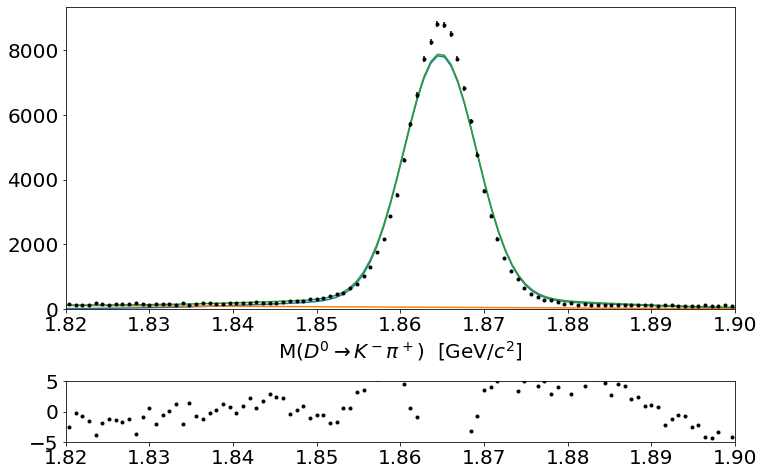

In [80]:
Dplot_model(model=d_pdf_ext, mydata=d_data, nevents=int(d_data_size), mylabel=r'M($D^0\rightarrow K^- \pi^+$)  [GeV/$c^{2}$]')

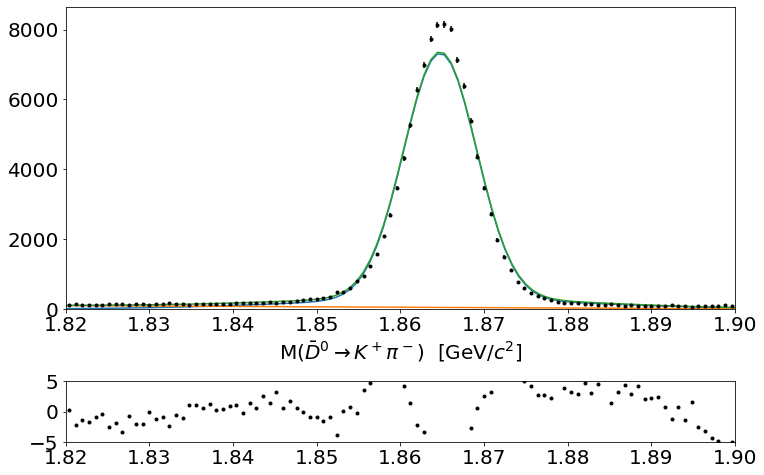

In [81]:
Dplot_model(model=ad_pdf_ext, mydata=ad_data, nevents=int(ad_data_size), mylabel=r'M($\barD^0\rightarrow K^+ \pi^-$)  [GeV/$c^{2}$]')

In [82]:
nd.append(result.params[d_sig_yield].get('value'))
nde.append(result.params[d_sig_yield].get('hesse').get('error'))
nad.append(result.params[ad_sig_yield].get('value'))
nade.append(result.params[ad_sig_yield].get('hesse').get('error'))

In [83]:
print(ndtrue)
print(nd)
print(nadtrue)
print(nad)

[177161, 112508]
[179527.33974009467, 118492.88180861178]
[170063, 104907]
[172383.42794991302, 110679.109438229]


In [84]:
import uncertainties as un
from uncertainties import unumpy

In [85]:
dar = unumpy.uarray(nd,nde)
adar = unumpy.uarray(nad,nade)

In [86]:
ndtruee = np.sqrt(ndtrue)
nadtruee = np.sqrt(nadtrue)

In [87]:
trdar = unumpy.uarray(ndtrue,ndtruee)
tradar = unumpy.uarray(nadtrue,nadtruee)

# A$_{CP}$ Determination

In [88]:
def getAsym(sig,asig,ctr,actr,d,ad):
    a1 = ((sig[0]-asig[0])/(sig[0]+asig[0])+(sig[1]-asig[1])/(sig[1]+asig[1]))/2
          
    a2 = ((ctr[0]-actr[0])/(ctr[0]+actr[0])+(ctr[1]-actr[1])/(ctr[1]+actr[1]))/2
    
    a3 = ((d[0]-ad[0])/(d[0]+ad[0])+(d[1]-ad[1])/(d[1]+ad[1]))/2
    
     
    acp = a1-a2+a3     
    
    return acp

In [89]:
getAsym(trsigar,trasigar,trctrar,tractrar,trdar,tradar)

0.027628469107067635+/-0.012367620689866276

In [90]:
getAsym(sigar,asigar,ctrar,actrar,trdar,tradar)

0.0488593329498319+/-0.02262068986024179

In [91]:
print(sigar-trsigar)

[61.03675398653036+/-90.38570070815953
 115.15152414837303+/-89.19129108772033]


In [92]:
print(ctrar-trctrar)

[-4660.827864015446+/-667.4632361800872
 -4106.058614427326+/-638.2339866371035]


In [93]:
print(dar-adar)

[7143.91179018165+/-646.8189820292995 7813.77237038278+/-504.1317614365627]
